In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import polars as ps
import seaborn as sb
import pymc3 as pm
from theano import shared, tensor
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
from sklearn.model_selection import train_test_split
import math

In [4]:
dataset: ps.DataFrame = ps.read_csv('full_dataset.csv', encoding='utf8')

In [5]:
dataset

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64
9,2022,6,1,0,40,1,0,1.4,0.0,0.6,0.3,2.8,9.0,20.0,14.0,3.8,24.7,28.5,121,1.3,13.0,8.0
56,2022,6,1,0,23,0,0,1.5,0.0,0.2,0.1,5.5,16.8,16.0,13.0,1.3,14.9,16.2,227,1.6,6.0,5.0
72,2022,6,1,1,15,1,0,1.4,1.0,0.2,0.2,6.1,10.2,24.0,15.0,1.4,3.8,5.2,149,0.3,5.0,2.0
27,2022,6,1,2,17,0,0,1.2,1.0,0.2,0.1,10.7,17.0,24.0,15.0,0.4,7.0,7.4,197,1.9,8.0,5.0
54,2022,6,1,2,33,0,0,2.4,1.0,0.1,0.1,2.0,11.3,19.0,13.0,2.3,20.4,22.8,331,0.6,8.0,7.0
48,2022,6,1,3,26,0,0,1.0,1.0,0.2,0.1,1.1,7.4,28.0,21.0,2.6,13.2,15.8,88,1.3,11.0,8.0
27,2022,6,1,4,19,0,0,1.0,1.0,0.1,0.1,13.9,16.5,20.0,18.0,0.0,1.7,1.6,185,2.9,6.0,5.0
65,2022,6,1,5,13,1,0,0.6,1.0,0.1,0.1,7.0,9.7,16.0,13.0,0.4,2.7,3.1,164,0.2,0.0,0.0
84,2022,6,1,7,20,1,0,0.3,0.0,0.1,0.1,14.0,14.2,18.0,20.0,1.3,4.5,5.8,230,1.5,1.0,2.0


<Axes: >

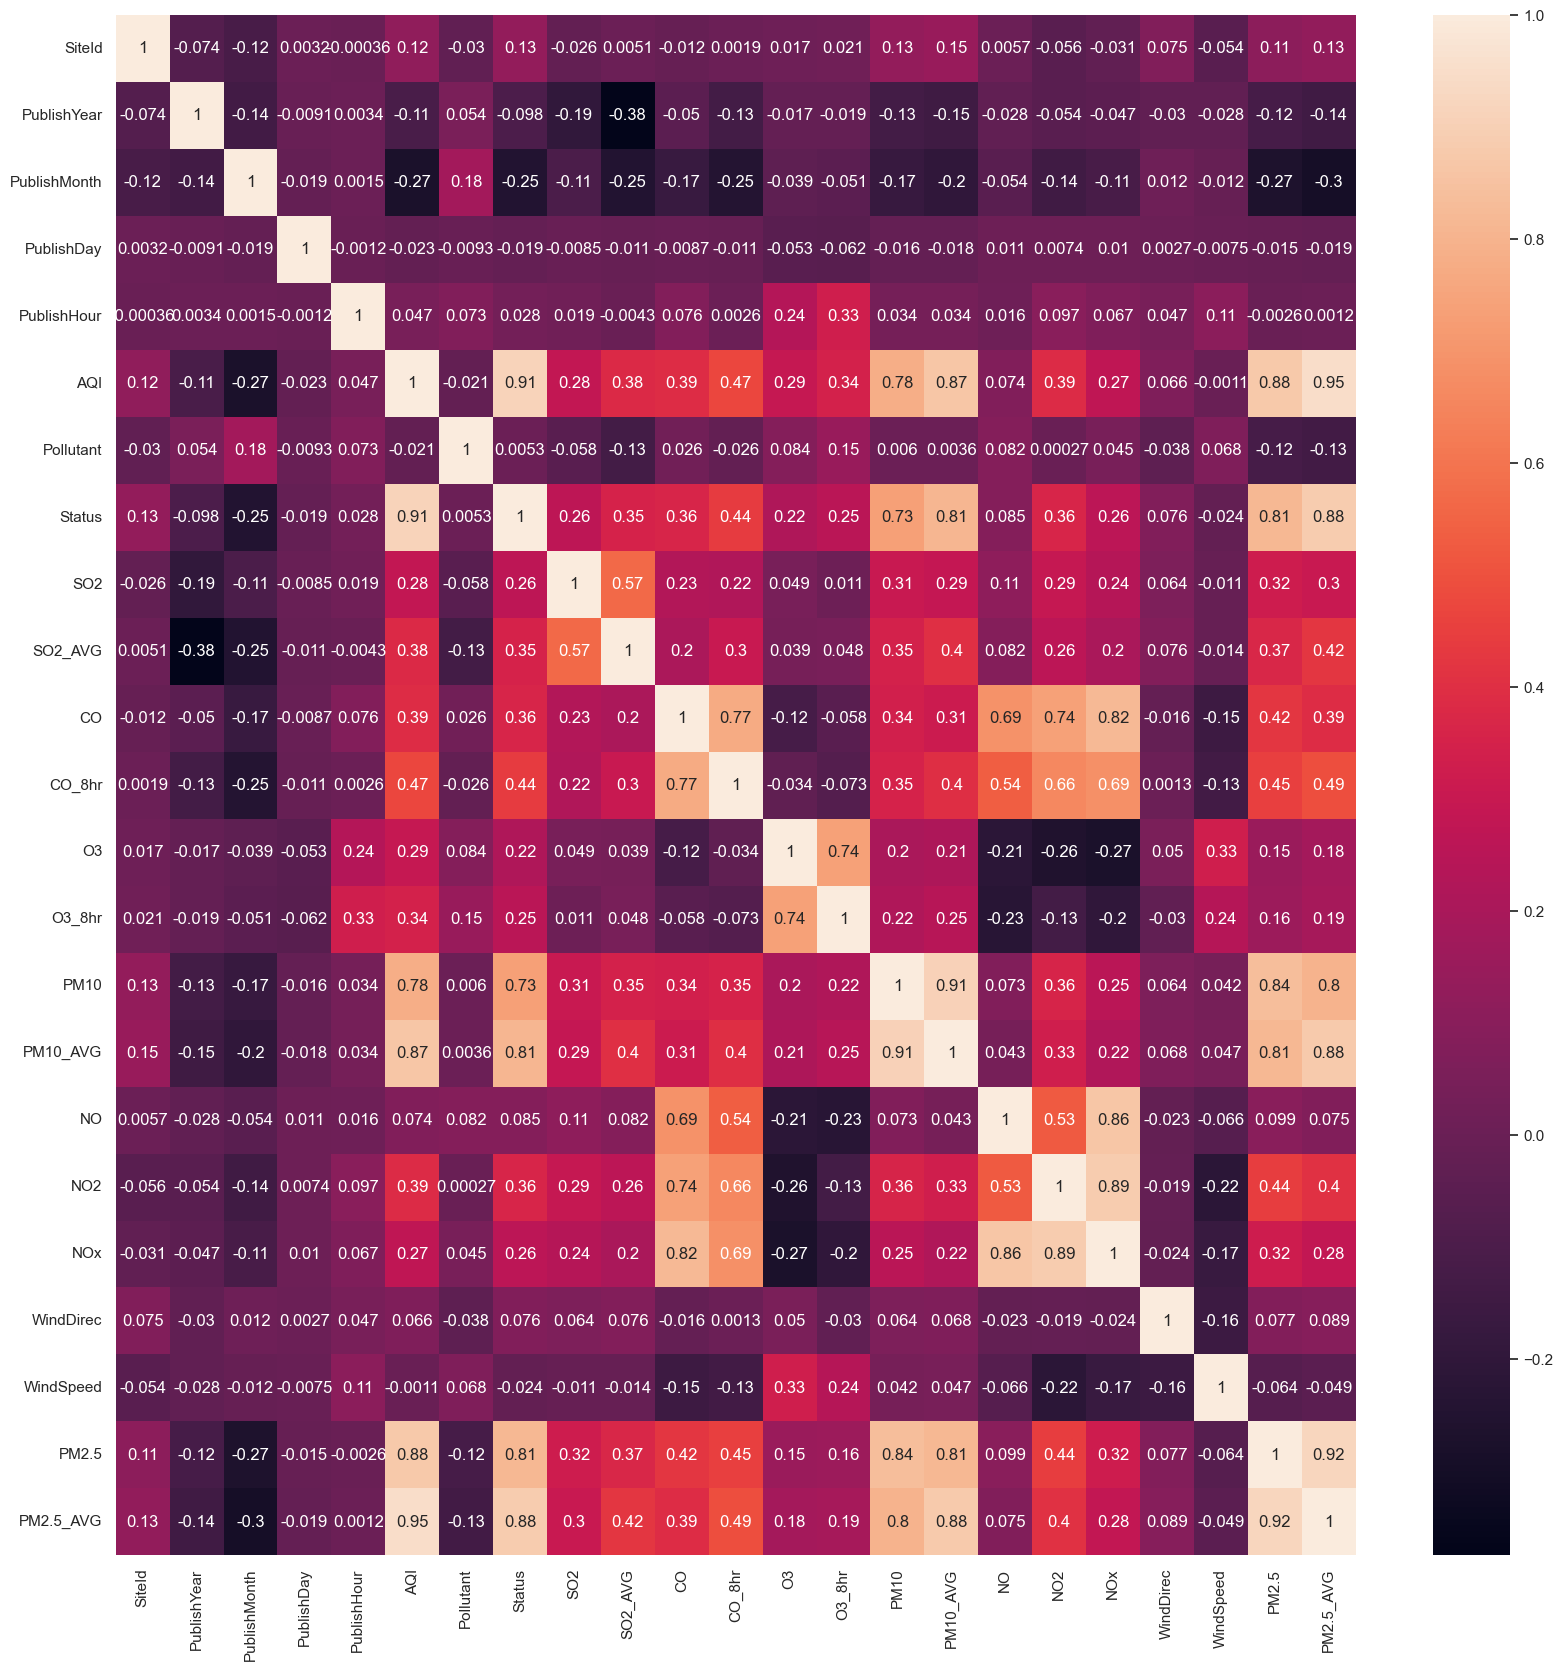

In [6]:
# sb.set(rc={'figure.figsize': (20, 20)})
# sb.heatmap(dataset.to_pandas().corr(), annot=True)

In [5]:
features: list = ['AQI', 'Status', 'PM10', 'PM10_AVG', 'PM2.5_AVG']

In [6]:
variables: list = [shared(dataset[feature].to_numpy(writable=True)) for feature in features]

In [7]:
target = dataset['PM2.5'].to_numpy(writable=True)

In [8]:
dataset[features]

AQI,Status,PM10,PM10_AVG,PM2.5_AVG
i64,i64,f64,f64,f64
55,1,29.0,32.0,17.0
68,1,52.0,39.0,22.0
50,0,25.0,25.0,15.0
49,0,24.0,30.0,15.0
72,1,29.0,36.0,24.0
63,1,35.0,30.0,20.0
48,0,17.0,21.0,15.0
82,1,40.0,48.0,28.0
34,0,13.0,13.0,9.0


In [9]:
len(target)

1218300

In [10]:
with pm.Model() as predictor:
    α = pm.Normal("α", sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=5) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(dataset[features][:100000], β)
    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
    # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=target[:100000])

    trace = pm.sample(tune=2000, chains=2, cores=2)
    ppc = pm.sample_posterior_predictive(trace, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 924 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

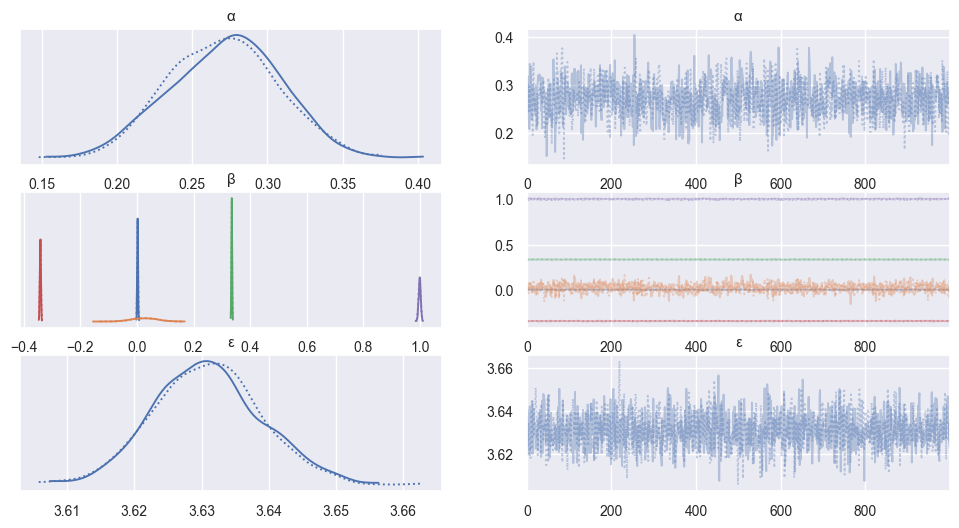

In [11]:
az.plot_trace(trace, var_names = ["α","β",'ε'])

In [12]:
az.summary(trace, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.271,0.037,0.203,0.336,0.001,0.001,1028.0,1171.0,1.0
β[0],0.002,0.002,-0.001,0.005,0.000,0.000,891.0,1050.0,1.0
β[1],0.026,0.045,-0.052,0.116,0.001,0.001,1081.0,1188.0,1.0
β[2],0.335,0.001,0.333,0.337,0.000,0.000,1672.0,1469.0,1.0
β[3],-0.341,0.002,-0.345,-0.338,0.000,0.000,1575.0,1236.0,1.0
β[4],0.999,0.004,0.992,1.006,0.000,0.000,1323.0,938.0,1.0
ε,3.631,0.008,3.616,3.646,0.000,0.000,1665.0,1440.0,1.0


In [5]:
dataset

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64
9,2022,6,1,0,40,1,0,1.4,0.0,0.6,0.3,2.8,9.0,20.0,14.0,3.8,24.7,28.5,121,1.3,13.0,8.0
56,2022,6,1,0,23,0,0,1.5,0.0,0.2,0.1,5.5,16.8,16.0,13.0,1.3,14.9,16.2,227,1.6,6.0,5.0
72,2022,6,1,1,15,1,0,1.4,1.0,0.2,0.2,6.1,10.2,24.0,15.0,1.4,3.8,5.2,149,0.3,5.0,2.0
27,2022,6,1,2,17,0,0,1.2,1.0,0.2,0.1,10.7,17.0,24.0,15.0,0.4,7.0,7.4,197,1.9,8.0,5.0
54,2022,6,1,2,33,0,0,2.4,1.0,0.1,0.1,2.0,11.3,19.0,13.0,2.3,20.4,22.8,331,0.6,8.0,7.0
48,2022,6,1,3,26,0,0,1.0,1.0,0.2,0.1,1.1,7.4,28.0,21.0,2.6,13.2,15.8,88,1.3,11.0,8.0
27,2022,6,1,4,19,0,0,1.0,1.0,0.1,0.1,13.9,16.5,20.0,18.0,0.0,1.7,1.6,185,2.9,6.0,5.0
65,2022,6,1,5,13,1,0,0.6,1.0,0.1,0.1,7.0,9.7,16.0,13.0,0.4,2.7,3.1,164,0.2,0.0,0.0
84,2022,6,1,7,20,1,0,0.3,0.0,0.1,0.1,14.0,14.2,18.0,20.0,1.3,4.5,5.8,230,1.5,1.0,2.0


In [6]:
dataset.null_count()

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
x = dataset[:300000].drop("PM2.5")

In [12]:
x

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5_AVG
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64
9,2022,6,1,0,40,1,0,1.4,0.0,0.6,0.3,2.8,9.0,20.0,14.0,3.8,24.7,28.5,121,1.3,8.0
56,2022,6,1,0,23,0,0,1.5,0.0,0.2,0.1,5.5,16.8,16.0,13.0,1.3,14.9,16.2,227,1.6,5.0
72,2022,6,1,1,15,1,0,1.4,1.0,0.2,0.2,6.1,10.2,24.0,15.0,1.4,3.8,5.2,149,0.3,2.0
27,2022,6,1,2,17,0,0,1.2,1.0,0.2,0.1,10.7,17.0,24.0,15.0,0.4,7.0,7.4,197,1.9,5.0
54,2022,6,1,2,33,0,0,2.4,1.0,0.1,0.1,2.0,11.3,19.0,13.0,2.3,20.4,22.8,331,0.6,7.0
48,2022,6,1,3,26,0,0,1.0,1.0,0.2,0.1,1.1,7.4,28.0,21.0,2.6,13.2,15.8,88,1.3,8.0
27,2022,6,1,4,19,0,0,1.0,1.0,0.1,0.1,13.9,16.5,20.0,18.0,0.0,1.7,1.6,185,2.9,5.0
65,2022,6,1,5,13,1,0,0.6,1.0,0.1,0.1,7.0,9.7,16.0,13.0,0.4,2.7,3.1,164,0.2,0.0
84,2022,6,1,7,20,1,0,0.3,0.0,0.1,0.1,14.0,14.2,18.0,20.0,1.3,4.5,5.8,230,1.5,2.0


In [13]:
y = dataset[:300000]["PM2.5"]

In [14]:
y

PM2.5
f64
13.0
6.0
5.0
8.0
8.0
11.0
6.0
0.0
1.0


In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [16]:
x_train.shape

(180000, 22)

In [29]:
features: list = ['AQI', 'Status', 'PM10', 'PM10_AVG', 'PM2.5_AVG']

In [30]:
with pm.Model() as predictor:
    α = pm.Normal("α", sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=5) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(x_train[features], β)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y_train)

    trace = pm.sample(tune=2000, chains=2, cores=2)
    ppc = pm.sample_posterior_predictive(trace, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1650 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

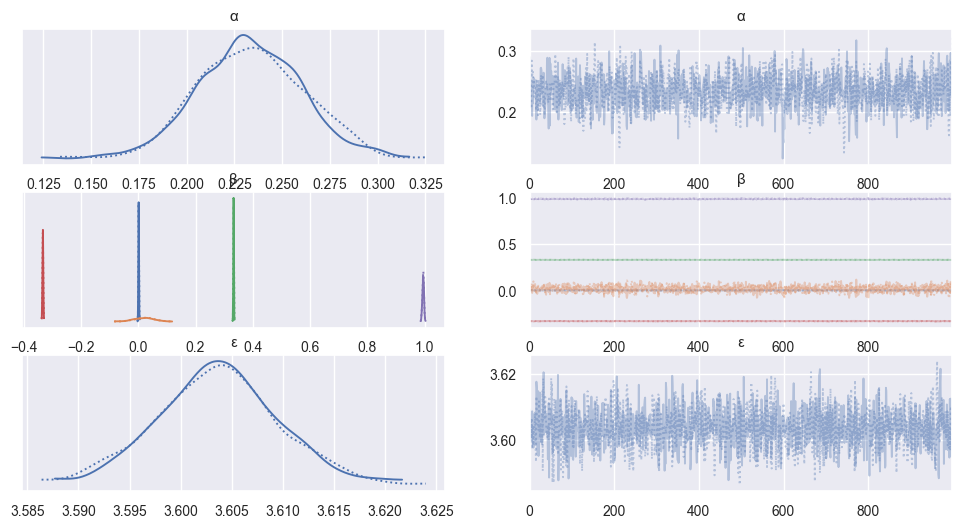

In [31]:
az.plot_trace(trace, var_names = ["α","β",'ε'])

In [32]:
az.summary(trace, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.233,0.027,0.184,0.285,0.001,0.001,1162.0,1284.0,1.0
β[0],0.001,0.001,-0.001,0.003,0.000,0.000,1157.0,1185.0,1.0
β[1],0.020,0.034,-0.038,0.090,0.001,0.001,1281.0,1145.0,1.0
β[2],0.333,0.001,0.331,0.335,0.000,0.000,1291.0,1163.0,1.0
β[3],-0.333,0.001,-0.336,-0.331,0.000,0.000,1390.0,1289.0,1.0
β[4],0.995,0.003,0.990,1.000,0.000,0.000,1252.0,1096.0,1.0
ε,3.604,0.006,3.593,3.615,0.000,0.000,1684.0,1189.0,1.0


In [32]:
MSE = 0.0
for i in range(0, len(y_test)):
    predict_y = 0.233 + x_test[i]['AQI'] * 0.001 + x_test[i]['Status'] * 0.020 + x_test[i]['PM10'] * 0.333 + x_test[i]['PM10_AVG'] * (- 0.333) + x_test[i]['PM2.5_AVG'] * 0.995
    MSE += math.sqrt(( y_test[i] - predict_y[0]) ** 2)

MSE /= len(y_test)

In [34]:
print("MSE:", MSE)

MSE: 2.4546617266666244


In [35]:
dataset['PM2.5'].mean()

14.772939834195148

In [36]:
dataset['PM2.5'].std()

11.684686960828033

In [18]:
# features_2: list = ['AQI', 'Status', 'CO', 'CO_8hr', 'NO2']

In [19]:
# with pm.Model() as predictor_2:
#    α = pm.Normal("α", sd=10)
#    β = pm.Normal('β', mu=0, sd=1, shape=5) 
#    ε = pm.HalfCauchy('ε', 5)
#    μ = α + pm.math.dot(x_train[features_2], β)
#    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
#   # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
#    y_pred_2 = pm.Normal('y_pred', mu=μ, sd=ε, observed=y_train)

#    trace_2 = pm.sample(tune=2000, chains=2, cores=2)
#    ppc_2 = pm.sample_posterior_predictive(trace_2, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1641 seconds.


NameError: name 'trace' is not defined

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

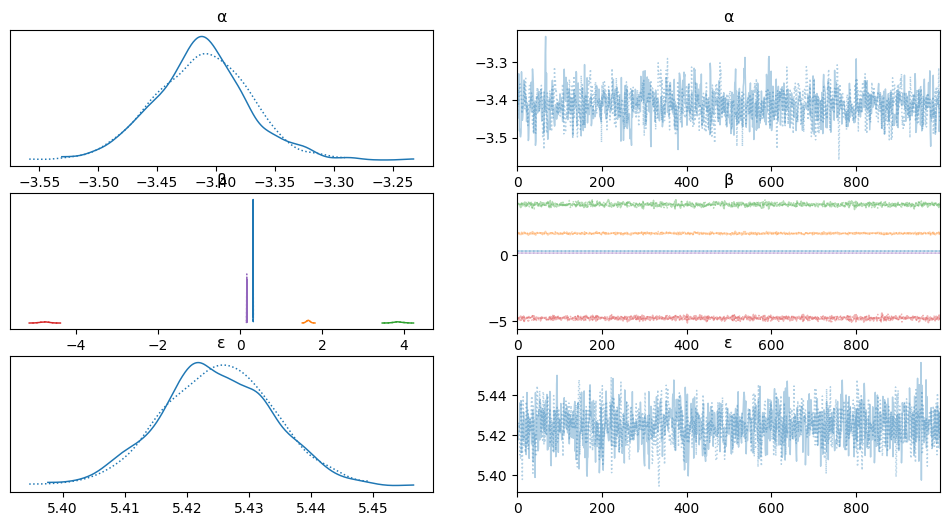

In [21]:
# az.plot_trace(trace_2, var_names = ["α","β",'ε'])

In [22]:
# az.summary(trace_2, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.413,0.040,-3.491,-3.341,0.001,0.001,1066.0,1115.0,1.0
β[0],0.320,0.001,0.317,0.322,0.000,0.000,1020.0,1080.0,1.0
β[1],1.662,0.049,1.565,1.750,0.002,0.001,1047.0,1110.0,1.0
β[2],3.852,0.112,3.660,4.082,0.003,0.002,1163.0,1246.0,1.0
β[3],-4.770,0.106,-4.979,-4.576,0.003,0.002,1484.0,1321.0,1.0
β[4],0.165,0.003,0.160,0.170,0.000,0.000,1078.0,1151.0,1.0
ε,5.425,0.009,5.408,5.442,0.000,0.000,1440.0,1163.0,1.0


In [37]:
# MSE_2 = 0.0
# for i in range(0, len(y_test)):
#     predict_y_2 = -3.413 + x_test[i]['AQI'] * 0.320 + x_test[i]['Status'] * 1.662 + x_test[i]['CO'] * 3.852 + x_test[i]['CO_8hr'] * (- 4.770) + x_test[i]['NO2'] * 0.165
#    MSE_2 += math.sqrt(( y_test[i] - predict_y_2[0] ) ** 2)

# MSE_2 /= len(y_test)

In [38]:
# print("MSE:", MSE_2)

MSE: 3.791212460833351


In [24]:
# features_3: list = ['SiteId','PublishMonth','AQI', 'Status', 'CO_8hr']

In [25]:
# with pm.Model() as predictor_3:
#    α = pm.Normal("α", sd=10)
#    β = pm.Normal('β', mu=0, sd=1, shape=5) 
#    ε = pm.HalfCauchy('ε', 5)
#    μ = α + pm.math.dot(x_train[features_3], β)
#    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
#    # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
#    y_pred_3 = pm.Normal('y_pred', mu=μ, sd=ε, observed=y_train)

#    trace_3 = pm.sample(tune=2000, chains=2, cores=2)
#    ppc_3 = pm.sample_posterior_predictive(trace_3, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 992 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

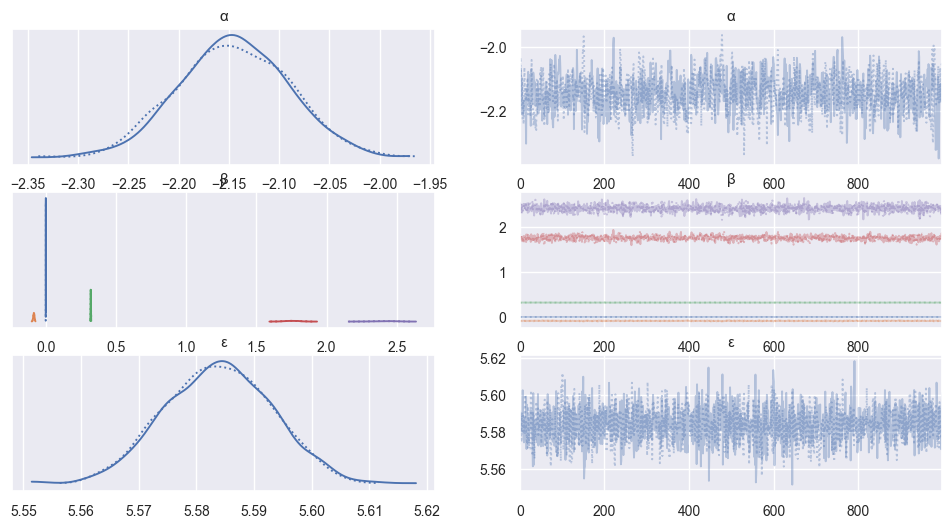

In [26]:
# az.plot_trace(trace_3, var_names = ["α","β",'ε'])

In [27]:
# az.summary(trace_3, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-2.145,0.056,-2.246,-2.038,0.002,0.001,720.0,1093.0,1.0
β[0],0.001,0.000,0.001,0.002,0.000,0.000,1800.0,1384.0,1.0
β[1],-0.084,0.004,-0.093,-0.076,0.000,0.000,1216.0,1266.0,1.0
β[2],0.321,0.001,0.319,0.323,0.000,0.000,952.0,1150.0,1.0
β[3],1.751,0.050,1.652,1.837,0.002,0.001,1026.0,1229.0,1.0
β[4],2.408,0.074,2.281,2.558,0.002,0.001,1572.0,1574.0,1.0
ε,5.584,0.009,5.567,5.601,0.000,0.000,2065.0,1228.0,1.0


In [39]:
# MSE_3 = 0.0
# for i in range(0, len(y_test)):
#     predict_y_3 = -2.145 + x_test[i]['SiteId'] * 0.001 + x_test[i]['PublishMonth'] * (-0.084) + x_test[i]['AQI'] * 0.321 + x_test[i]['Status'] * 1.751 + x_test[i]['CO_8hr'] * 2.408
#    MSE_3 += math.sqrt(( y_test[i] - predict_y_3[0] ) ** 2)

# MSE_3 /= len(y_test)

In [40]:
# print("MSE:", MSE_3)

MSE: 3.885886883333313
